# Case study of the december 6 2021 storm melting layer in altitude


---

**Author**: Olivier Chalifour
**Organisation**: UQAM
**Date**: 26 July 2021

---

In [1]:
"""
Import
"""
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import os
import glob
import sys
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error
import scipy.stats
import math
import time as time_mod
import xarray as xr
sys.path.insert(0, "/home/chalifour/code/master")
import fct_script.rpn_funcs_chris as rpn_chris
from fct_script.get_domain import get_domain_info
from fct_script.func_py import get_colormap_precip,categorical_cmap
from matplotlib.patches import Patch
# from func_py import get_proj_extent

try:
    import rpnpy.librmn.all as rmn  # Module to read RPN files
    from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
except ImportError as err:
    print(f"RPNPY can only be use on the server. It can't be use on a personal computer."
          f"\nError throw :{err}")

In [12]:

#event 1
# date = '2021-11-17 23'
# f_hr = 30

#event 2
# date = '2022-03-06 06'
# f_hr = 30

#event 3
date = '2021-12-06 05'
f_hr = 30


datetimeobject = datetime.strptime(date, '%Y-%m-%d %H')
new_format = datetimeobject.strftime('%Y%m%d')
format_rpn_file = datetimeobject.strftime('%Y%m')

run = pd.Timestamp(fr'{date}')


valid_time = run + pd.Timedelta(str(f_hr) + ' h')
timestamps = pd.date_range(run, valid_time, freq='1 H')
time = timestamps

start = run
end = valid_time


In [13]:
# Simulation Data path

path_dict_sim_11km = fr'/chinook/roberge/Output/GEM5/Olivier/NAM-11m_ERA5_GEM50_PCPTYPEnil'
file_name_20211_11km = f'Samples/NAM-11m_ERA5_GEM50_PCPTYPEnil_{format_rpn_file}'
path_202112_11km = [os.path.join(path_dict_sim_11km, file_name_20211_11km)]

path_dict_sim_2p5km = '/chinook/roberge/Output/GEM5/Olivier/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil'
file_name_20211_2p5km = f'Samples/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil_{format_rpn_file}'
path_202112_2p5km = [os.path.join(path_dict_sim_2p5km, file_name_20211_2p5km)]



path_data_saving = f"/upslope/chalifour/projet_maitrise/data_sim_station/data_alt_P3_{run.year}{run.month}"

# image output dir
image_output_dir = "/upslope/chalifour/projet_maitrise/fig/case_analysis"

# Important information
image_output_dpi = 200

# lat,lon station à étudier
lat_momo = 47.322437368331876
lon_momo = -71.14730110000002


# Get data altitude for each simulation

- P3
- Temp en altitude

In [14]:
# Data P3 constant
pressure_level = [1000.,975.,950.,925.,900.,850.,800.,700.,600.,500.,400.,300.,250.,200.,150.,100.]
ip1_list=[]
for pres in pressure_level:
    ip1_pres = rmn.ip1_val(pres, rmn.LEVEL_KIND_PMB)
    ip1_list.append(ip1_pres)
# variable: rain masse mixing ration, ice masse mixing ration, rime masse mixing ration, total equivalent reflectivity
variable_alt = ["TT",'MPQR','QTI1','QMI1','GZ','ZET','P0']
# variable_alt = ['P0']
var_name=["Temperature [\u2103]","Rain mass mixing ratio [kg/kg]","Total mass mixing ratio for ice category 1 [kg/kg]","Rime mass mixing ratio for ice category 1[kg/kg]"]


In [6]:
# get champs physique dans dp file
for reso, path_alt in zip(["11km","2p5km"],[path_202112_11km[0]+'/dp*',path_202112_2p5km[0]+'/dp*']):
    data_alt_dict = {'time':time}
    variable_alt = ["TT",'MPQR','QTI1','QMI1','GZ']


    for var in variable_alt:
        data_alt_dict[var]=[]

    dict_idx_nearest_pt={'NEIGE':[]}
    t0 = time_mod.time()




    fid = rmn.fstopenall(path_alt,rmn.FST_RO)

    for i,timestamp in enumerate(time):
        print(f"Getting data of the {timestamp}")
        for var in variable_alt:

            data_alt_momo_1h=[]
            for ip1_val in ip1_list:

                datev = rpn_chris.date_to_datev(timestamp)
                key1 = rmn.fstinf(fid, nomvar=var)

                rec = rmn.fstlirx(key1, fid, nomvar=var, datev=datev,ip1=ip1_val)

                mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
                latlondict = rmn.gdll(mygrid)
                lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
                lon_var = latlondict['lon']

                if len(dict_idx_nearest_pt['NEIGE']) == 0:

                    pyt = (lon_var-(360+lon_momo))**2+(lat_var-lat_momo)**2

                    idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
                    dict_idx_nearest_pt['NEIGE'] = [idx_lat,idx_lon]

                    var_pt = [rec['d'][idx_lat,idx_lon]]
                else:
                    idx_lat,idx_lon = dict_idx_nearest_pt['NEIGE']
                    var_pt=[rec['d'][idx_lat,idx_lon]]
                data_alt_momo_1h.append(var_pt[0])
            data_alt_dict[var].append(data_alt_momo_1h)



    rmn.fstcloseall(fid)                        # Close the RPN file

    t1 = time_mod.time()
    total_n = t1-t0

    for var in variable_alt:
        data_var = data_alt_dict[var]
        df_var = pd.DataFrame(data_var,index=data_alt_dict['time'],columns=pressure_level)
        df_var.to_csv(os.path.join(path_data_saving,f"{reso}/{var}.csv"))


    print(f'Time: {total_n}')

Getting data of the 2021-12-06 05:00:00
Getting data of the 2021-12-06 06:00:00
Getting data of the 2021-12-06 07:00:00
Getting data of the 2021-12-06 08:00:00
Getting data of the 2021-12-06 09:00:00


KeyboardInterrupt: 

In [25]:
# get P0 from dm file
for reso, path_alt in zip(["11km","2p5km"],[path_202112_11km[0]+'/dm*',path_202112_2p5km[0]+'/dm*']):
    data_alt_dict = {'time':time}

    data_alt_dict['P0']=[]
    dict_idx_nearest_pt={'NEIGE':[]}
    t0 = time_mod.time()

    fid = rmn.fstopenall(path_alt,rmn.FST_RO)
    data_alt_momo_1h=[]

    for i,timestamp in enumerate(time):
        print(f"Getting data of the {timestamp}")

        datev = rpn_chris.date_to_datev(timestamp)
        key1 = rmn.fstinf(fid, nomvar='P0')
        rec = rmn.fstlirx(key1, fid, nomvar='P0', datev=datev)

        # rec = rmn.fstlir(fid, nomvar=var, datev=datev, ip1=ip1_val)

        mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
        latlondict = rmn.gdll(mygrid)
        lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
        lon_var = latlondict['lon']

        if len(dict_idx_nearest_pt['NEIGE']) == 0:

            pyt = (lon_var-(360+lon_momo))**2+(lat_var-lat_momo)**2

            idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
            dict_idx_nearest_pt['NEIGE'] = [idx_lat,idx_lon]

            var_pt = [rec['d'][idx_lat,idx_lon]]
        else:
            idx_lat,idx_lon = dict_idx_nearest_pt['NEIGE']
            var_pt=[rec['d'][idx_lat,idx_lon]]

        data_alt_momo_1h.append(var_pt[0])
    data_alt_dict['P0'].append(data_alt_momo_1h)



    rmn.fstcloseall(fid)                        # Close the RPN file

    t1 = time_mod.time()
    total_n = t1-t0

    data_var = data_alt_dict['P0']
    df_var = pd.DataFrame(data_var,index=data_alt_dict['time'])
    df_var.to_csv(os.path.join(path_data_saving,f"{reso}/P0.csv"))


    print(f'Time: {total_n}')

Getting data of the 2021-12-06 05:00:00
Getting data of the 2021-12-06 06:00:00
Getting data of the 2021-12-06 07:00:00
Getting data of the 2021-12-06 08:00:00
Getting data of the 2021-12-06 09:00:00
Getting data of the 2021-12-06 10:00:00
Getting data of the 2021-12-06 11:00:00
Getting data of the 2021-12-06 12:00:00
Getting data of the 2021-12-06 13:00:00
Getting data of the 2021-12-06 14:00:00
Getting data of the 2021-12-06 15:00:00
Getting data of the 2021-12-06 16:00:00
Getting data of the 2021-12-06 17:00:00
Getting data of the 2021-12-06 18:00:00
Getting data of the 2021-12-06 19:00:00
Getting data of the 2021-12-06 20:00:00
Getting data of the 2021-12-06 21:00:00
Getting data of the 2021-12-06 22:00:00
Getting data of the 2021-12-06 23:00:00
Getting data of the 2021-12-07 00:00:00
Getting data of the 2021-12-07 01:00:00
Getting data of the 2021-12-07 02:00:00
Getting data of the 2021-12-07 03:00:00
Getting data of the 2021-12-07 04:00:00
Getting data of the 2021-12-07 05:00:00


In [26]:
# get ZET reflectance from pp file
for reso, path_alt in zip(["11km","2p5km"],[path_202112_11km[0]+'/pp*',path_202112_2p5km[0]+'/pp*']):
    data_alt_dict = {'time':time}

    data_alt_dict['ZET']=[]

    dict_idx_nearest_pt={'UQAM_PK':[],'NEIGE':[]}
    t0 = time_mod.time()


    fid = rmn.fstopenall(path_alt,rmn.FST_RO)

    for i,timestamp in enumerate(time):
        print(f"Getting data of the {timestamp}")
        data_alt_momo_1h=[]
        for ip1_val in ip1_list:
            datev = rpn_chris.date_to_datev(timestamp)
            key1 = rmn.fstinf(fid, nomvar='ZET')
            rec = rmn.fstlirx(key1, fid, nomvar='ZET', datev=datev,ip1=ip1_val)

            # rec = rmn.fstlir(fid, nomvar=var, datev=datev, ip1=ip1_val)

            mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
            latlondict = rmn.gdll(mygrid)
            lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
            lon_var = latlondict['lon']

            if len(dict_idx_nearest_pt['NEIGE']) == 0:

                pyt = (lon_var-(360+lon_momo))**2+(lat_var-lat_momo)**2

                idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
                dict_idx_nearest_pt['NEIGE'] = [idx_lat,idx_lon]

                var_pt = [rec['d'][idx_lat,idx_lon]]
            else:
                idx_lat,idx_lon = dict_idx_nearest_pt['NEIGE']
                var_pt=[rec['d'][idx_lat,idx_lon]]

            # var_pt = rmn.gdllsval(mygrid, [lat_momo], [lon_momo], rec['d']) #Get value of var interpolated to lat/lon point
            data_alt_momo_1h.append(var_pt[0])
        data_alt_dict['ZET'].append(data_alt_momo_1h)




    rmn.fstcloseall(fid)                        # Close the RPN file

    t1 = time_mod.time()
    total_n = t1-t0

    data_var = data_alt_dict['ZET']
    df_var = pd.DataFrame(data_var,index=data_alt_dict['time'],columns=pressure_level)
    df_var.to_csv(os.path.join(path_data_saving,f"{reso}/ZET.csv"))


    print(f'Time: {total_n}')

Getting data of the 2021-12-06 05:00:00
Getting data of the 2021-12-06 06:00:00
Getting data of the 2021-12-06 07:00:00
Getting data of the 2021-12-06 08:00:00
Getting data of the 2021-12-06 09:00:00
Getting data of the 2021-12-06 10:00:00
Getting data of the 2021-12-06 11:00:00
Getting data of the 2021-12-06 12:00:00
Getting data of the 2021-12-06 13:00:00
Getting data of the 2021-12-06 14:00:00
Getting data of the 2021-12-06 15:00:00
Getting data of the 2021-12-06 16:00:00
Getting data of the 2021-12-06 17:00:00
Getting data of the 2021-12-06 18:00:00
Getting data of the 2021-12-06 19:00:00
Getting data of the 2021-12-06 20:00:00
Getting data of the 2021-12-06 21:00:00
Getting data of the 2021-12-06 22:00:00
Getting data of the 2021-12-06 23:00:00
Getting data of the 2021-12-07 00:00:00
Getting data of the 2021-12-07 01:00:00
Getting data of the 2021-12-07 02:00:00
Getting data of the 2021-12-07 03:00:00
Getting data of the 2021-12-07 04:00:00
Getting data of the 2021-12-07 05:00:00


# Radar data at NEIGE

In [17]:
#event 1
path_data=glob.glob(f"/instruments/FORET_MONTMORENCY/Site_Neige/mrr/{run.year}_0{run.month}/master/FM_SN_MRR_MAS_220{run.month}0*[6-7].nc")
#event 2
path_data=glob.glob(f"/instruments/FORET_MONTMORENCY/Site_Neige/mrr/{run.year}_{run.month}/master/FM_SN_MRR_MAS_21{run.month}1*[8-9].nc")
#event 3
path_data=glob.glob(f"/instruments/FORET_MONTMORENCY/Site_Neige/mrr/{run.year}_{run.month}/master/FM_SN_MRR_MAS_21{run.month}0*[6-7].nc")

print(path_data)

['/instruments/FORET_MONTMORENCY/Site_Neige/mrr/2021_11/master/FM_SN_MRR_MAS_211118.nc', '/instruments/FORET_MONTMORENCY/Site_Neige/mrr/2021_11/master/FM_SN_MRR_MAS_211119.nc']


In [18]:
nc = []
for i in range(len(path_data)):
    nc.append(xr.open_dataset(path_data[i]))

nc = xr.concat(nc, dim='time')



ds = nc.sel(time=slice(str(start), str(end)))

# found in ds.properties
alt_radar = 664 /1000 # m->km



# Figure

In [19]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return f"{s}\u2103" if plt.rcParams["text.usetex"] else f"{s}\u2103"

def fmt_ZE(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return f"{s}\u2103" if plt.rcParams["text.usetex"] else f"{s}"
def get_time_height(nc):
    time   = np.array(rpn_chris.dt64_to_datetime(nc.time))
    dt     = time[1]-time[0]
    height =  nc.height.data[0]/ 1000 + alt_radar # meters to kilometers

    # pas mal sure que ya un offset de 1.4km
    # height = nc.range.data / 1000 - 1.4  # meters to kilometers

    dh  = height[1]-height[0]


    return time,dt,height,dh

def W_plot(nc, ax, fs=12):
    time, dt, height, dh = get_time_height(nc)

    '''
    Colormap construction
    '''

    nb_couleur = 256
    level = np.linspace(-1, 8, nb_couleur)

    cmap1 = np.array([np.linspace(mcolors.to_rgba('r')[i], mcolors.to_rgba('lightgrey')[i], 10) for i in range(4)]).T
    cmap2 = np.array([np.linspace(mcolors.to_rgba('lightgrey')[i], mcolors.to_rgba('b')[i], 20) for i in range(4)]).T
    cmap3 = np.array([np.linspace(mcolors.to_rgba('b')[i], mcolors.to_rgba('g')[i], 20) for i in range(4)]).T
    cmap4 = np.array([np.linspace(mcolors.to_rgba('g')[i], mcolors.to_rgba('y')[i], 20) for i in range(4)]).T
    cmap4 = np.array([np.linspace(mcolors.to_rgba('y')[i], mcolors.to_rgba('C1')[i], 20) for i in range(4)]).T
    cmap_12 = np.concatenate([cmap1, cmap2, cmap3, cmap4])

    cmap_brg = mcolors.LinearSegmentedColormap.from_list('', cmap_12, N=1000)

    '''
    Plot and colorbar
    '''
    # print((height-dh/2)[10], nc.W.T[10])
    cmesh = ax.pcolormesh(time-dt/2, height-dh/2, nc.W.T, cmap=cmap_brg, vmin=-1, vmax=8, shading='auto')
    # ax.set_ylim([ height[0] , height[-1] ])
    # ax.set_xlim([time[0],time[-1]])
    return ax,cmesh


def ze_plot(nc, ax, fs=12):
    time, dt, height, dh = get_time_height(nc)

    '''
    Cmap construction
    '''

    env_can = ['#98CCFE', '#0099FE', '#00FF65', '#00CC02', '#009902' \
        , '#006601', '#FEFF34', '#FFCC00', '#FF9900', '#FF6600', \
               '#FF0000', '#FE0399', '#9934CC', '#660199']

    env_can_ar = np.linspace(0, 45, 100)
    cmap_fr = mcolors.LinearSegmentedColormap.from_list('', env_can, N=1000)
    norm = mcolors.BoundaryNorm(boundaries=env_can_ar, ncolors=1000)

    '''
    Plot and colorbar
    '''
    # print(height-dh/2)
    # print(nc.Ze.T)
    cmesh = ax.pcolormesh(time-dt/2, height-dh/2 , nc.Ze.T, cmap=cmap_fr, vmin=0, vmax=45,shading='auto')
    # CS1 = ax.contour(time-dt/2, height-dh/2 , nc.Ze.T, [30],
    #                                        linestyles="--", linewidths=1, colors='k')
    # ax.set_ylim([height[0], height[-1]])
    # ax.set_xlim([time[0], time[-1]])
    return ax,cmesh

In [20]:
list_cmap = ['Greens','Blues','Oranges']
for k,cmap_i in enumerate(list_cmap):
    cmap = cm.get_cmap(cmap_i, 256)
    cmap = cmap(np.linspace(0, 1, 256))[::40]
    cmap = ListedColormap(cmap)

    norm = BoundaryNorm([0.001,0.01,0.05,0.1,0.5,1,3,6], cmap.N)
    list_cmap[k] = cmap


<ipython-input-21-3a624f942769>:107: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cmesh_11km = ax_ze_11km.pcolormesh(time_mesh,df_gz.values.T,np.ma.masked_where(df_ZET.values.T<=0,df_ZET.values.T), cmap=cmap_fr, vmin=0, vmax=45,shading='auto')
<ipython-input-21-3a624f942769>:193: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cmesh_2p5km = ax_ze_2p5km.pcolormesh(time_mesh,df_gz.values.T,np.ma.masked_where(df_ZET.values.T<=0,df_ZET.values.T), cmap=cmap_fr, vmin=0, vmax=45,shading='auto')


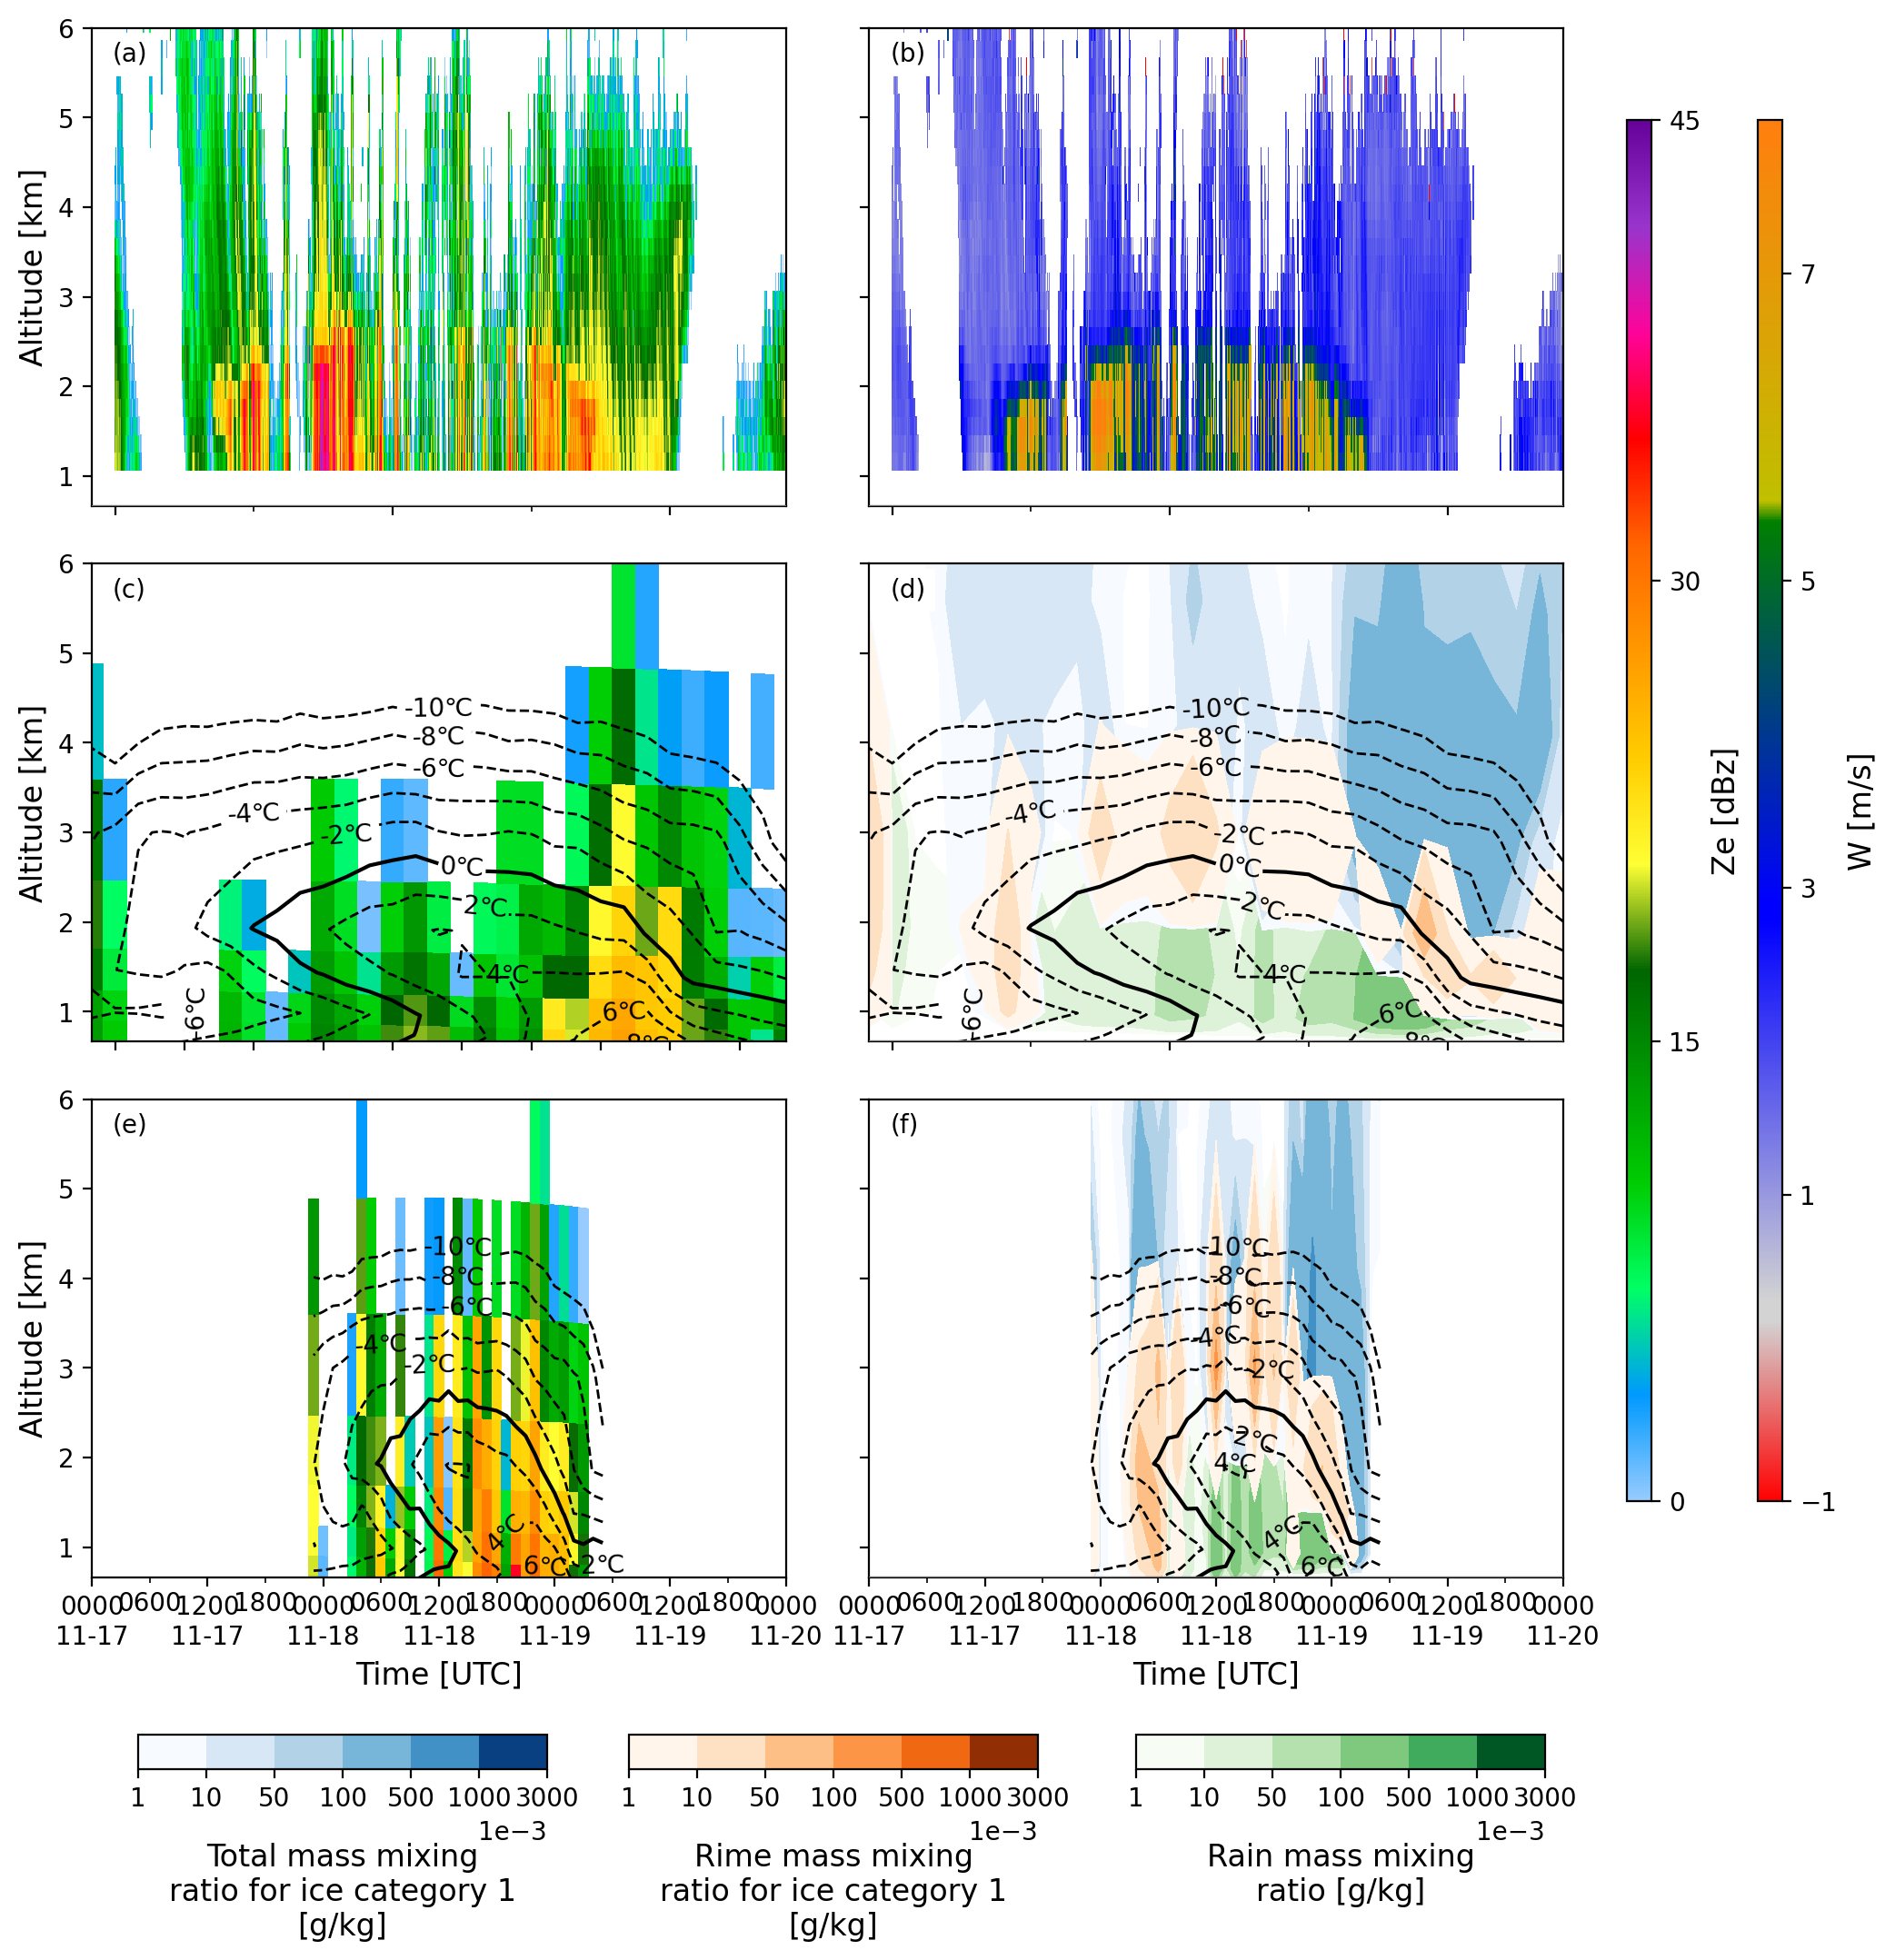

In [21]:
# Changer pour ne pas utiliser grid spec et utiliser des ax noral ça vas etre plus simple
# , figsize=(4 * 1.5, 4 *1.5)
fig = plt.figure(facecolor='white',figsize=(9, 9.5),dpi=image_output_dpi)

# spec = fig.add_gridspec(nrows=750,ncols=700,)
# spec = fig.add_gridspec(nrows=505,ncols=485)
# Ze
ax_ze = fig.add_subplot(321)
# ax_ze = fig.add_subplot(spec[0:200,0:200])
# W
ax_w = fig.add_subplot(322)

ax_ze_11km = fig.add_subplot(323)
# ax_ze = fig.add_subplot(spec[0:200,0:200])
# W
ax_ze_2p5km = fig.add_subplot(325)
# ax_w = fig.add_subplot(spec[0:200,205:405])
# P3 11km
ax_p3_11km = fig.add_subplot(324)
# ax_p3_11km = fig.add_subplot(spec[205:405,0:200])
# P3 2p5km
ax_p3_2p5km = fig.add_subplot(326)
# ax_p3_2p5km = fig.add_subplot(spec[205:405,205:405])

list_axs=[ax_ze,ax_w,ax_p3_11km,ax_p3_2p5km]
for ax in list_axs:
    # ax.set_aspect('equal')
    ax.sharex(list_axs[0])
    ax.sharey(list_axs[0])

# colorbar ax
for ax in [ax_ze,ax_w,ax_ze_11km,ax_ze_2p5km,ax_p3_11km,ax_p3_2p5km]:
    ax.grid(False)

    ax.tick_params(axis='both',which="both",left=True,bottom=True)
    ax.set_xlim(time[0],time[-1])



ymax=6


# plt ze
ax_ze, cmesh_ze = ze_plot(ds, ax_ze)



ax_ze.set_ylabel('Altitude [km]', fontsize=12)
ax_ze.tick_params(which="both",bottom=True,labelbottom=False)
ax_ze.tick_params(axis='y', labelsize=10)
ax_ze.set_xlim(time[0],time[-1])
ax_ze.set_ylim(alt_radar,ymax)
ax_ze.axhspan(0,alt_radar,alpha=1, color='grey',zorder=9999999)


# plt w
ax_w, cmesh_w = W_plot(ds, ax_w)




# ax_w.set_ylim(0.5,2)
ax_w.set_xlim(time[0],time[-1])
ax_w.set_ylim(alt_radar,ymax)
ax_w.axhspan(0,alt_radar,alpha=1, color='grey',zorder=9999999)
ax_w.tick_params(axis='both',which="both",left=True,bottom=True,labelleft=False,labelbottom=False)
# plot P3 11 km

reso='11km'

path_gz = os.path.join(path_data_saving,f'{reso}/GZ.csv')
df_gz = pd.read_csv(path_gz,header=0,index_col=0, parse_dates=True)*10/1000

mask_data = df_gz< (alt_radar)

path_TT = os.path.join(path_data_saving,f'{reso}/TT.csv')
df_TT = pd.read_csv(path_TT,header=0,index_col=0, parse_dates=True)

path_MPQR = os.path.join(path_data_saving,f'{reso}/MPQR.csv')
df_MPQR = pd.read_csv(path_MPQR,header=0,index_col=0, parse_dates=True)*1000 # kg->g

path_QTI1 = os.path.join(path_data_saving,f'{reso}/QTI1.csv')
df_QTI1 = pd.read_csv(path_QTI1,header=0,index_col=0, parse_dates=True)*1000 # kg->g

path_QMI1 = os.path.join(path_data_saving,f'{reso}/QMI1.csv')
df_QMI1 = pd.read_csv(path_QMI1,header=0,index_col=0, parse_dates=True)*1000 # kg->g

path_ZET = os.path.join(path_data_saving,f'{reso}/ZET.csv')
df_ZET = pd.read_csv(path_ZET,header=0,index_col=0, parse_dates=True) # kg->g




env_can = ['#98CCFE', '#0099FE', '#00FF65', '#00CC02', '#009902' \
        , '#006601', '#FEFF34', '#FFCC00', '#FF9900', '#FF6600', \
               '#FF0000', '#FE0399', '#9934CC', '#660199']


levels = [0.001,0.01,0.05,0.1,0.5,1,3]
norm = BoundaryNorm(levels,len(levels))
time_mesh,pres_mesh = np.meshgrid(time,pressure_level)

env_can_ar = np.linspace(0, 45, 100)
cmap_fr = mcolors.LinearSegmentedColormap.from_list('', env_can, N=1000)
norm_ze = mcolors.BoundaryNorm(boundaries=env_can_ar, ncolors=1000)

cmesh_11km = ax_ze_11km.pcolormesh(time_mesh,df_gz.values.T,np.ma.masked_where(df_ZET.values.T<=0,df_ZET.values.T), cmap=cmap_fr, vmin=0, vmax=45,shading='auto')

# rain
cmap_rain = ax_p3_11km.contourf(time_mesh,df_gz.values.T,df_MPQR.values.T,cmap=list_cmap[0],levels=levels,norm=norm)
# ice
cmap_ice = ax_p3_11km.contourf(time_mesh,df_gz.values.T,df_QTI1.values.T,cmap=list_cmap[1],levels=levels,norm=norm)
# ice Rime
cmap_rime = ax_p3_11km.contourf(time_mesh,df_gz.values.T,df_QMI1.values.T,cmap=list_cmap[2],levels=levels,norm=norm)



# temp
bound_contour = np.arange(-10, 13, 2)
bound_contour = bound_contour[bound_contour != 0]

CS1 = ax_p3_11km.contour(time_mesh,df_gz.values.T,df_TT.values.T, bound_contour,
                                           linestyles="--", linewidths=1, colors='k')
CS2 = ax_p3_11km.contour(time_mesh,df_gz.values.T,df_TT.values.T, [0],
                                           linestyles="-", linewidths=1.5, colors='k')

clabels_1 = ax_p3_11km.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)
clabels_2 = ax_p3_11km.clabel(CS2, CS2.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)

CS3 = ax_ze_11km.contour(time_mesh,df_gz.values.T,df_TT.values.T, bound_contour,
                                           linestyles="--", linewidths=1, colors='k')
CS4 = ax_ze_11km.contour(time_mesh,df_gz.values.T,df_TT.values.T, [0],
                                           linestyles="-", linewidths=1.5, colors='k')
clabels_3 = ax_ze_11km.clabel(CS3, CS3.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)
clabels_4 = ax_ze_11km.clabel(CS4, CS4.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)

locator_minor = mdates.HourLocator(interval=6)
locator_major = mdates.HourLocator(interval=12)
ax_ze_2p5km.set_xlabel('Time [UTC]', fontsize=12)
ax_ze_2p5km.set_ylabel('Altitude [km]', fontsize=12)
ax_ze_2p5km.xaxis.set_major_locator(locator_major)
ax_ze_2p5km.xaxis.set_minor_locator(locator_minor)
ax_ze_2p5km.xaxis.set_major_formatter(mdates.DateFormatter("%H%M\n%m-%d"))
ax_ze_2p5km.xaxis.set_minor_formatter(mdates.DateFormatter("%H%M"))
ax_ze_2p5km.tick_params(axis='x', which='major', labelsize=10)
ax_ze_2p5km.tick_params(axis='x', which='minor', labelsize=10)
ax_ze_2p5km.tick_params(axis='y', labelsize=10)

ax_p3_11km.set_ylim(alt_radar,ymax)
ax_ze_11km.set_ylim(alt_radar,ymax)
ax_ze_11km.set_ylabel('Altitude [km]', fontsize=12)
ax_ze_11km.tick_params(which="both",bottom=True,labelbottom=False)
ax_ze_11km.tick_params(axis='both',which="both",left=True,bottom=True,labelbottom=False)

ax_p3_11km.axhspan(0,alt_radar,alpha=1, color='grey',zorder=9999999)




# plot p3 2.5km
reso='2p5km'

path_gz = os.path.join(path_data_saving,f'{reso}/GZ.csv')
df_gz = pd.read_csv(path_gz,header=0,index_col=0, parse_dates=True)*10/1000

mask_data = df_gz< (alt_radar)

path_TT = os.path.join(path_data_saving,f'{reso}/TT.csv')
df_TT = pd.read_csv(path_TT,header=0,index_col=0, parse_dates=True)



path_MPQR = os.path.join(path_data_saving,f'{reso}/MPQR.csv')
df_MPQR = pd.read_csv(path_MPQR,header=0,index_col=0, parse_dates=True)*1000 # kg->g


path_QTI1 = os.path.join(path_data_saving,f'{reso}/QTI1.csv')
df_QTI1 = pd.read_csv(path_QTI1,header=0,index_col=0, parse_dates=True)*1000 # kg->g

path_QMI1 = os.path.join(path_data_saving,f'{reso}/QMI1.csv')
df_QMI1 = pd.read_csv(path_QMI1,header=0,index_col=0, parse_dates=True)*1000 # kg->g

path_ZET = os.path.join(path_data_saving,f'{reso}/ZET.csv')
df_ZET = pd.read_csv(path_ZET,header=0,index_col=0, parse_dates=True) # kg->g


time_mesh,pres_mesh = np.meshgrid(time,pressure_level)


cmesh_2p5km = ax_ze_2p5km.pcolormesh(time_mesh,df_gz.values.T,np.ma.masked_where(df_ZET.values.T<=0,df_ZET.values.T), cmap=cmap_fr, vmin=0, vmax=45,shading='auto')
# rain
cmap_rain = ax_p3_2p5km.contourf(time_mesh,df_gz.values.T,df_MPQR.values.T,cmap=list_cmap[0],levels=levels,norm=norm)
# ice
cmap_ice = ax_p3_2p5km.contourf(time_mesh,df_gz.values.T,df_QTI1.values.T,cmap=list_cmap[1],levels=levels,norm=norm)
# ice Rime
cmap_rime = ax_p3_2p5km.contourf(time_mesh,df_gz.values.T,df_QMI1.values.T,cmap=list_cmap[2],levels=levels,norm=norm)


# temp
bound_contour = np.arange(-10, 13, 2)
bound_contour = bound_contour[bound_contour != 0]

CS1 = ax_p3_2p5km.contour(time_mesh,df_gz.values.T,df_TT.values.T, bound_contour,
                                           linestyles="--", linewidths=1, colors='k')
CS2 = ax_p3_2p5km.contour(time_mesh,df_gz.values.T,df_TT.values.T, [0],
                                           linestyles="-", linewidths=1.5, colors='k')
clabels_1 = ax_p3_2p5km.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)
clabels_2 = ax_p3_2p5km.clabel(CS2, CS2.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)


CS3 = ax_ze_2p5km.contour(time_mesh,df_gz.values.T,df_TT.values.T, bound_contour,
                                           linestyles="--", linewidths=1, colors='k')
CS4 = ax_ze_2p5km.contour(time_mesh,df_gz.values.T,df_TT.values.T, [0],
                                           linestyles="-", linewidths=1.5, colors='k')
clabels_3 = ax_ze_2p5km.clabel(CS3, CS3.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)
clabels_4 = ax_ze_2p5km.clabel(CS4, CS4.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=True)
# # ZET
bound_contour = np.arange(0, 45, 10)


# ax_p3_2p5km.sharey(ax_w)
ax_p3_2p5km.set_ylim(alt_radar,ymax)
ax_ze_2p5km.set_ylim(alt_radar,ymax)

ax_p3_11km.tick_params(axis='both',which="both",left=True,bottom=True,labelleft=False,labelbottom=False)
locator_minor = mdates.HourLocator(interval=6)
locator_major = mdates.HourLocator(interval=12)
ax_p3_2p5km.set_xlabel('Time [UTC]', fontsize=12)
ax_p3_2p5km.xaxis.set_major_locator(locator_major)
ax_p3_2p5km.xaxis.set_minor_locator(locator_minor)
ax_p3_2p5km.xaxis.set_major_formatter(mdates.DateFormatter("%H%M\n%m-%d"))
ax_p3_2p5km.xaxis.set_minor_formatter(mdates.DateFormatter("%H%M"))
ax_p3_2p5km.tick_params(axis='x', which='major', labelsize=10)
ax_p3_2p5km.tick_params(axis='x', which='minor', labelsize=10)


ax_p3_2p5km.axhspan(0,alt_radar,alpha=1, color='grey',zorder=9999999)
ax_p3_2p5km.set_xlim(time[0],time[-1])
ax_p3_2p5km.tick_params(axis='y',which="both",left=True,labelleft=False,bottom = True)


bbox = dict(boxstyle="square", fc="w",ec='white')
ax_ze.annotate(f'(a)', xy=(0.03, 0.93), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax_w.annotate(f'(b)', xy=(0.03, 0.93), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax_ze_11km.annotate('(c)', xy=(0.03, 0.93), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax_ze_2p5km.annotate('(e)', xy=(0.03, 0.93), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax_p3_11km.annotate(f'(d)', xy=(0.03, 0.93), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax_p3_2p5km.annotate(f'(f)', xy=(0.03, 0.93), bbox=bbox, xycoords='axes fraction', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(wspace=0.12,
                    hspace=0.12)

# colorbar
cbaxes_ze = fig.add_axes([1, 0.125, 0.015, 0.8])


cbZe = plt.colorbar(cmesh_ze,ax=[ax_w,ax_ze,ax_p3_11km,ax_p3_2p5km],cax=cbaxes_ze)
cbZe.set_label('Ze [dBz]', fontsize=12)
cbZe.set_ticks([-15, 0, 15, 30, 45])
cbZe.ax.tick_params(labelsize=10)

cbaxes_w = fig.add_axes([1.08, 0.125, 0.015, 0.8])
cbw = plt.colorbar(cmesh_w,ax=[ax_w,ax_ze,ax_p3_11km,ax_p3_2p5km] ,cax=cbaxes_w)
cbw.set_label('W [m/s]',fontsize=12)
cbw.set_ticks([-1, 1, 3, 5, 7])
cbw.ax.tick_params(labelsize=10)


class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

cbaxes_ice = fig.add_axes([0.09, -0.03, 1/4, 0.02],anchor='C')
cbar_ice = plt.colorbar(cmap_ice,cax=cbaxes_ice,orientation='horizontal',format=OOMFormatter(-3,fformat="%1.0f", mathText=False))
cbar_ice.set_ticks(levels)
cbar_ice.ax.tick_params(labelsize=10)
cbar_ice.set_label("Total mass mixing\nratio for ice category 1\n[g/kg]",fontsize=12,labelpad=12)

cbaxes_rime = fig.add_axes([0.39, -0.03, 1/4, 0.02],anchor='C')
cbar_rime = plt.colorbar(cmap_rime,cax=cbaxes_rime,aspect=40,orientation='horizontal',format=OOMFormatter(-3,fformat="%1.0f", mathText=False))
cbar_rime.set_ticks(levels)
cbar_rime.ax.tick_params(labelsize=10)
cbar_rime.set_label("Rime mass mixing\nratio for ice category 1\n[g/kg]",fontsize=12,labelpad=12)

cbaxes_rain = fig.add_axes([0.7, -0.03, 1/4, 0.02],anchor='C')



cbar_rain = plt.colorbar(cmap_rain,cax=cbaxes_rain ,aspect=40,orientation='horizontal',format=OOMFormatter(-3,fformat="%1.0f", mathText=False))
cbar_rain.set_ticks(levels)
cbar_rain.ax.tick_params(labelsize=10)
cbar_rain.set_label("Rain mass mixing\nratio [g/kg]",fontsize=12,labelpad=12)
# to save the figure uncomment those line
# path_phase_fig = f'/upslope/chalifour/projet_maitrise/fig/case_analysis/melting_layer/melting_layer_{new_format}.png'
# fig.savefig(path_phase_fig, dpi=image_output_dpi, format='png' , bbox_inches='tight',) # Most backends support png, pdf,
plt.show()
plt.close(fig)